<a href="https://colab.research.google.com/github/ImtiazAhammad/BERT-based-veracity-Assessment-with-Attention-Visualization/blob/main/Demo_BERT_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers

In [ ]:
!pip install accelerate -U
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 50.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.2
    Uninstalling transformers-4.37.2:
      Successfully uninstalled transformers-4.37.2


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Set the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
# Load the TruthSeeker dataset
df = pd.read_csv('/content/drive/MyDrive/Dataset/TruthSeeker2023/Truth_Seeker_Model_Dataset.csv')

In [ ]:

# Separate the dataset into true and fake tweets
df_true = df[df['BinaryNumTarget'] == 1.0]
df_fake = df[df['BinaryNumTarget'] == 0.0]

# Sample 250 from each class to maintain balance
df_true_sample = df_true.sample(250, random_state=42)
df_fake_sample = df_fake.sample(250, random_state=42)

# Combine and shuffle the samples
df_balanced = pd.concat([df_true_sample, df_fake_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Splitting the dataset into train, test, and validation sets (70:15:15)
train_df, test_df = train_test_split(df_balanced, test_size=0.3, random_state=42)  # 70% for training, 30% for test and validation
validation_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)  # Split the 30% into 15% test and 15% validation

# Check the size of each set
print(f"Training Set: {len(train_df)} samples")
print(f"Testing Set: {len(test_df)} samples")
print(f"Validation Set: {len(validation_df)} samples")


Training Set: 350 samples
Testing Set: 75 samples
Validation Set: 75 samples


In [ ]:
train_df.head()

,Unnamed: 0,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer
5,122345,Daniel Funke,At 17 years old Kyle (Rittenhouse) was perfect...,False,0.0,"Kyle,possess,rifle,legal",@SSon712 @Not_the_Bee Its legal for minors to ...,Mostly Agree,Agree
116,93903,Eric Stirgus,Sixteen million jobs were created under Ronald...,True,1.0,"16 million, jobs, created, Reagan",@HouseGOP Jobs created\nClinton 18.6 Million ...,Agree,Agree
45,40109,Louis Jacobson,"""There are more words in the IRS code than the...",True,1.0,"More words, IRS code, Bible","""There are more words in the IRS code than in ...",Mostly Agree,Agree
16,71551,Andy Nguyen,The unvaccinated have escaped every single str...,False,0.0,"unvaccinated, escape, variant",@thehowie @EricTopol My understanding though i...,Mostly Agree,Agree
462,73032,Louis Jacobson,"""The NRA used to support expanded background c...",True,1.0,"NRA, used to support, background checks",@StevenMoney @ChicagoPhotoSho @malenroh1 @Judd...,Agree,Agree


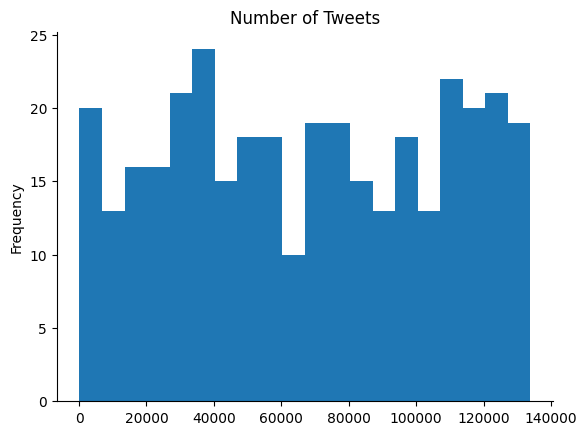

In [ ]:
# @title Unnamed: 0

from matplotlib import pyplot as plt
train_df['Unnamed: 0'].plot(kind='hist', bins=20, title='Number of Tweets')
plt.gca().spines[['top', 'right',]].set_visible(False)

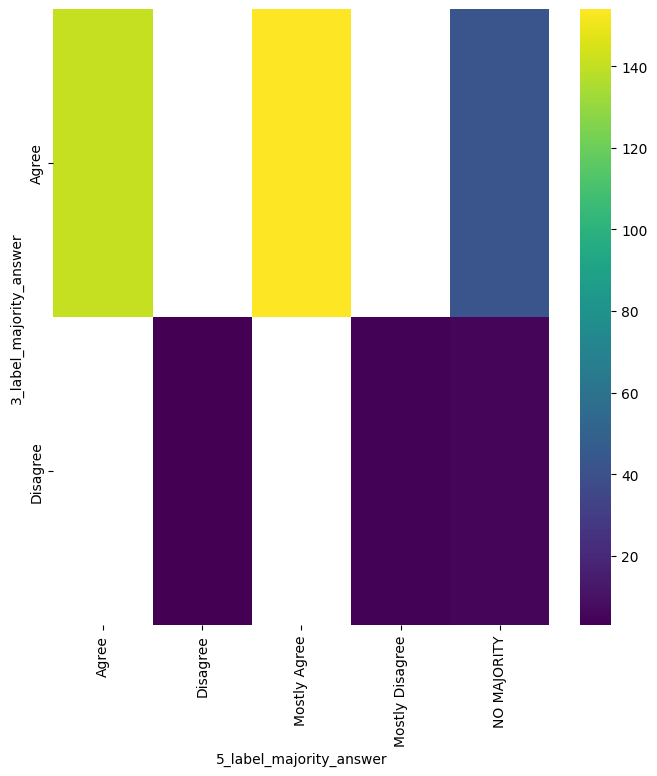

In [ ]:
# @title 5_label_majority_answer vs 3_label_majority_answer

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['3_label_majority_answer'].value_counts()
    for x_label, grp in train_df.groupby('5_label_majority_answer')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('5_label_majority_answer')
_ = plt.ylabel('3_label_majority_answer')

<ipython-input-19-e77801595368>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(train_df, x='Unnamed: 0', y='5_label_majority_answer', inner='stick', palette='Dark2')


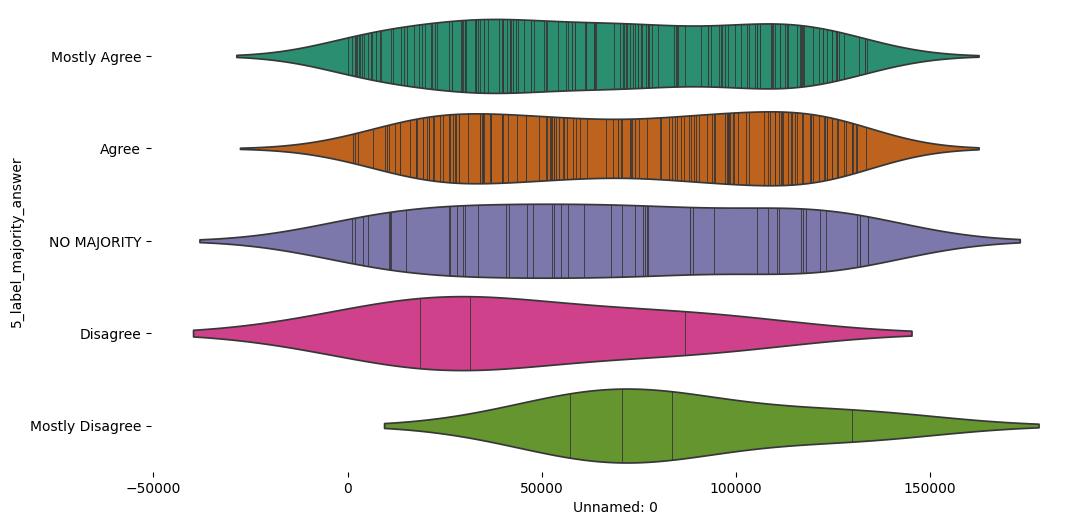

In [ ]:
# @title 5_label_majority_answer vs Unnamed: 0

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(train_df['5_label_majority_answer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train_df, x='Unnamed: 0', y='5_label_majority_answer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

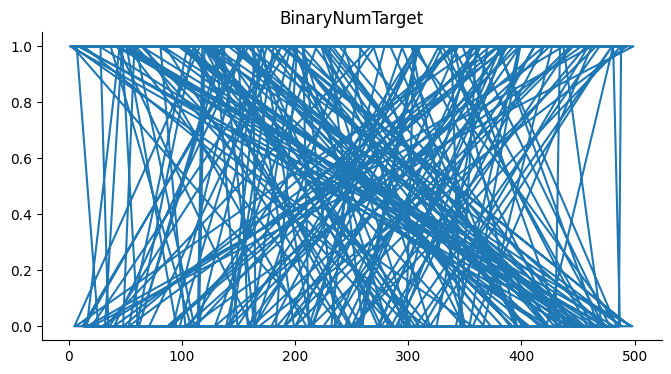

In [ ]:
# @title BinaryNumTarget

from matplotlib import pyplot as plt
train_df['BinaryNumTarget'].plot(kind='line', figsize=(8, 4), title='BinaryNumTarget')
plt.gca().spines[['top', 'right']].set_visible(False)

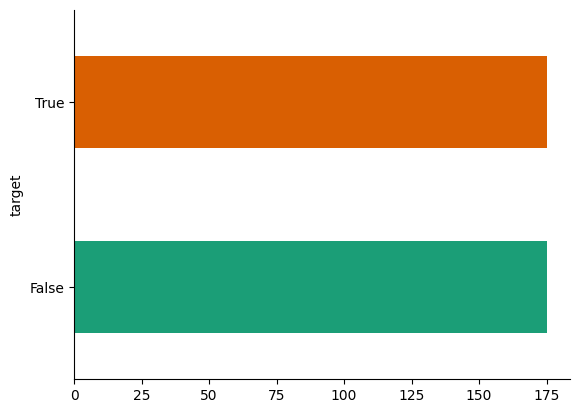

In [ ]:
# @title target

from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('target').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.head()

,Unnamed: 0,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer
0,0,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Mostly Agree,Agree
1,1,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,NO MAJORITY,Agree
2,2,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree
3,3,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Mostly Agree,Agree
4,4,D.L. Davis,End of eviction moratorium means millions of A...,True,1.0,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree


In [ ]:
df['BinaryNumTarget'].value_counts()

1.0    68930
0.0    65268
Name: BinaryNumTarget, dtype: int64

In [ ]:
df['statement'].value_counts()

Both the Democratic and Republican candidates for president in 2016 are "quite unpopular."                                                                                                                                                        499
"Crimea became part of Ukraine only in 1954. Crimea was historically part of Russia, and (Nikita) Khrushchev gave it to Ukraine in a gesture that mystified some people."                                                                         499
"Forty-seven percent of (members of Congress) are millionaires."                                                                                                                                                                                  499
All of the science and data say its perfectly safe to have teachers and students in the classroom.                                                                                                                                                499
Says Texas eithe

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import numpy as np
import random
import time
import datetime

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Dataset/TruthSeeker_700.csv')

# Select a subset of data for demonstration purposes
texts = df['tweet'].tolist()
labels = df['BinaryNumTarget'].tolist()

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
input_ids = []
attention_masks = []

# Tokenize all texts
for text in texts:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Train-validation split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.2)

# Create DataLoaders
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Load BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Tell model to run on GPU
model.cuda()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Helper function for calculating accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# Seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Training loop
epochs = 4
for epoch_i in range(0, epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    total_loss = 0
    model.train()




======== Epoch 1 / 4 ========
======== Epoch 2 / 4 ========
======== Epoch 3 / 4 ========
======== Epoch 4 / 4 ========


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
    print("\nRunning Validation...")

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()  # Ensure labels are of type torch.long

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits

            # Calculate the loss between predicted and true labels
            loss = torch.nn.functional.cross_entropy(logits, b_labels)
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print(f"  Accuracy: {avg_val_accuracy}")

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print(f"  Validation Loss: {avg_val_loss}")



Running Validation...
  Accuracy: 0.3715277777777778
  Validation Loss: 0.718209617667728


In [ ]:
!pip install lime


In [ ]:
def model_predict(texts):
    # Tokenize the input text and prepare it as a DataLoader
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    return predictions


In [ ]:
from lime.lime_text import LimeTextExplainer

# Create a LIME Text Explainer
explainer = LimeTextExplainer(class_names=["Fake", "Real"])

# Choose an instance to explain
idx = 100  # for example, the 10th instance in your dataset
text_instance = df['tweet'][idx]

# Generate explanation
exp = explainer.explain_instance(text_instance, model_predict, num_features=50)

# Show the explanation
print(exp.as_list())
exp.as_pyplot_figure()


OutOfMemoryError: CUDA out of memory. Tried to allocate 836.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 473.06 MiB is free. Process 18124 has 14.28 GiB memory in use. Of the allocated memory 12.09 GiB is allocated by PyTorch, and 2.07 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
df['tweet'][10]

'BREAKING NEWS: Mitch McConnell accuses President Biden of pushing socialism by implementing the eviction moratorium that will stop millions of Americans from being thrown out on the street this month. RT if you think that Mitch is a heartless idiot!'

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', output_attentions=True, num_labels=2)
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
def get_attention_weights(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    attentions = outputs.attentions  # Get attention weights
    return attentions


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(text, layer, head):
    # Get attention weights
    attentions = get_attention_weights(text)

    # Select the attention weights of the specified layer and head
    attention = attentions[layer][0, head].cpu().numpy()

    # Tokenize the input text to match tokens with attention weights
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(text)))

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Attention - Layer {layer + 1}, Head {head + 1}')
    plt.show()


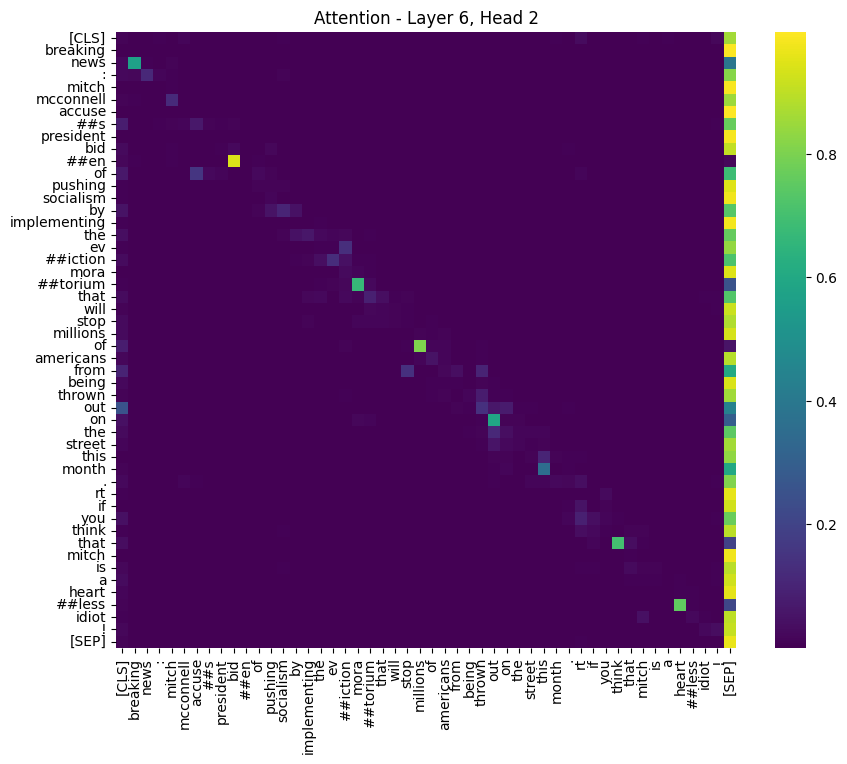

In [ ]:
text = "BREAKING NEWS: Mitch McConnell accuses President Biden of pushing socialism by implementing the eviction moratorium that will stop millions of Americans from being thrown out on the street this month. RT if you think that Mitch is a heartless idiot!"  # Replace with your input text
layer = 5   # Choose which layer to visualize (0 to 11 for BERT-base)
head = 1    # Choose which head to visualize (0 to 11 for BERT-base)

visualize_attention(text, layer, head)
